In [1]:
import numpy as np
from tqdm import tqdm
import xarray as xr
import matplotlib.pyplot as plt
import warnings
from itertools import product
from polarization_controller import optical_fiber, polarization_splitter_rotator, mzi, phase_aligner, polarization_bidi, polarization_bidi_double_fiber, polarization_bidi_single_fiber
from scipy.optimize import minimize
warnings.filterwarnings("ignore")
plt.style.use("plot_style.mplstyle")

# 

In [2]:
p_bidi = polarization_bidi(tx_num_mzi_stages = 1)

In [3]:
sample_points = 201

phase_shifts = np.linspace(-np.pi, np.pi, sample_points)

rotation_rx = phase_shifts[np.random.permutation(sample_points)]
rotation_ry = phase_shifts[np.random.permutation(sample_points)]
rotation_rz = phase_shifts[np.random.permutation(sample_points)]
rotation_delta = phase_shifts[np.random.permutation(sample_points)]

p_bidi.fiber_1._rotation = (rotation_rx[0], rotation_ry[0], rotation_rz[0], rotation_delta[0])
p_bidi.fiber_2._rotation = (rotation_rx[1], rotation_ry[1], rotation_rz[1], rotation_delta[1])
p_bidi.fiber_3._rotation = (rotation_rx[2], rotation_ry[2], rotation_rz[2], rotation_delta[2])
p_bidi.fiber_4._rotation = (rotation_rx[3], rotation_ry[3], rotation_rz[3], rotation_delta[3])
p_bidi.fiber_5._rotation = (rotation_rx[4], rotation_ry[4], rotation_rz[4], rotation_delta[4])
p_bidi.fiber_6._rotation = (rotation_rx[5], rotation_ry[5], rotation_rz[5], rotation_delta[5])
p_bidi.fiber_7._rotation = (rotation_rx[6], rotation_ry[6], rotation_rz[6], rotation_delta[6])

p_bidi.oc_1._return_loss = -35
p_bidi.oc_2._return_loss = -35
p_bidi.oc_3._return_loss = -35
p_bidi.oc_4._return_loss = -35
p_bidi.oc_5._return_loss = -35
p_bidi.oc_6._return_loss = -35

p_bidi.recursive_update()

In [4]:
no_sweep = 61
voltages = np.linspace(-3.0, 3.0, no_sweep)

transmit_tm_forward = []
transmit_te_forward  = []
reflect_te_forward = []
reflect_tm_forward = []

transmit_tm_reverse = []
transmit_te_reverse  = []
reflect_te_reverse = []
reflect_tm_reverse = []

input_state_forward = np.array([1, 0, 0, 0])
input_state_reverse = np.array([0, 0, 1, 0])

for tx_pa_voltage, tx_mzi_voltage in tqdm(product(voltages, voltages), total=no_sweep**2):
  p_bidi.bidi_tx.pa.XPS1.heater_voltage = 0.0
  p_bidi.bidi_tx.pa.XPS2.heater_voltage = 0.0
  if tx_pa_voltage > 0.0:
    p_bidi.bidi_tx.pa.XPS1.heater_voltage = tx_pa_voltage
  if tx_pa_voltage < 0.0:
    p_bidi.bidi_tx.pa.XPS2.heater_voltage = -tx_pa_voltage


  p_bidi.bidi_tx.mzi_1.XPS1.heater_voltage = 0.0
  p_bidi.bidi_tx.mzi_1.XPS2.heater_voltage = 0.0
  if tx_mzi_voltage > 0.0:
    p_bidi.bidi_tx.mzi_1.XPS1.heater_voltage = tx_mzi_voltage
  if tx_mzi_voltage < 0.0:
    p_bidi.bidi_tx.mzi_1.XPS2.heater_voltage = -tx_mzi_voltage
    
  p_bidi.recursive_update()

  output_state_forward = p_bidi.smatrix @ input_state_forward
  
  transmit_te_forward.append(np.abs(output_state_forward[2])**2)
  transmit_tm_forward.append(np.abs(output_state_forward[3])**2)
  reflect_te_forward.append(np.abs(output_state_forward[0])**2)
  reflect_tm_forward.append(np.abs(output_state_forward[1])**2)

  output_state_reverse = p_bidi.smatrix @ input_state_reverse
  
  transmit_te_reverse.append(np.abs(output_state_reverse[0])**2)
  transmit_tm_reverse.append(np.abs(output_state_reverse[1])**2)
  reflect_te_reverse.append(np.abs(output_state_reverse[2])**2)
  reflect_tm_reverse.append(np.abs(output_state_reverse[3])**2)

100%|██████████| 3721/3721 [00:02<00:00, 1683.28it/s]


In [5]:
index_mzi = np.argmax(transmit_tm_forward)%no_sweep
index_pa = int(np.argmax(transmit_tm_forward)/no_sweep)
print(voltages[index_mzi], voltages[index_pa])

1.8000000000000007 -0.7999999999999998


In [6]:
p_bidi.bidi_tx.pa.XPS1.heater_voltage = 0.0
p_bidi.bidi_rx.pa.XPS2.heater_voltage = 0.0

if voltages[index_pa] > 0.0:
  p_bidi.bidi_tx.pa.XPS1.heater_voltage = voltages[index_pa]
if voltages[index_pa] < 0.0:
  p_bidi.bidi_tx.pa.XPS2.heater_voltage = -voltages[index_pa]

p_bidi.bidi_tx.mzi_1.XPS1.heater_voltage = 0.0
p_bidi.bidi_tx.mzi_1.XPS2.heater_voltage = 0.0

if voltages[index_mzi] > 0.0:
  p_bidi.bidi_tx.mzi_1.XPS1.heater_voltage = voltages[index_mzi]
if voltages[index_mzi] < 0.0:
  p_bidi.bidi_tx.mzi_1.XPS2.heater_voltage = -voltages[index_mzi]

p_bidi.recursive_update()

In [7]:
input_state_forward = np.array([1, 0, 0, 0])
output_state_forward = p_bidi.smatrix @ input_state_forward
print("Output state direction: ", np.abs(output_state_forward)**2)
print("Output state direction in log: ", 10*np.log10(np.abs(output_state_forward)**2))

input_state_reverse = np.array([0, 0, 1, 0])
output_state_reverse = p_bidi.smatrix @ input_state_reverse
print("Output state reverse direction: ", np.abs(output_state_reverse)**2)
print("Output state direction in log: ", 10*np.log10(np.abs(output_state_reverse)**2))

Output state direction:  [2.34481297e-04 1.31469771e-04 9.57932996e-05 9.41000251e-02]
Output state direction in log:  [-36.29891793 -38.81174092 -40.18664867 -10.26410261]
Output state reverse direction:  [9.57932996e-05 1.04077304e-01 1.01859258e-04 5.70819742e-05]
Output state direction in log:  [-40.18664867  -9.82643967 -39.91999494 -42.43501015]


In [8]:
x_meshgrid, y_meshgrid = np.meshgrid(voltages, voltages)
index_mzi = np.argmax(transmit_tm_forward)%no_sweep
index_pa = int(np.argmax(transmit_tm_forward)/no_sweep)
print(voltages[index_mzi], voltages[index_pa])

1.8000000000000007 -0.7999999999999998


Text(0.5, 1.0, 'From Chip 1 MRM reflected back to Chip 1 MRM')

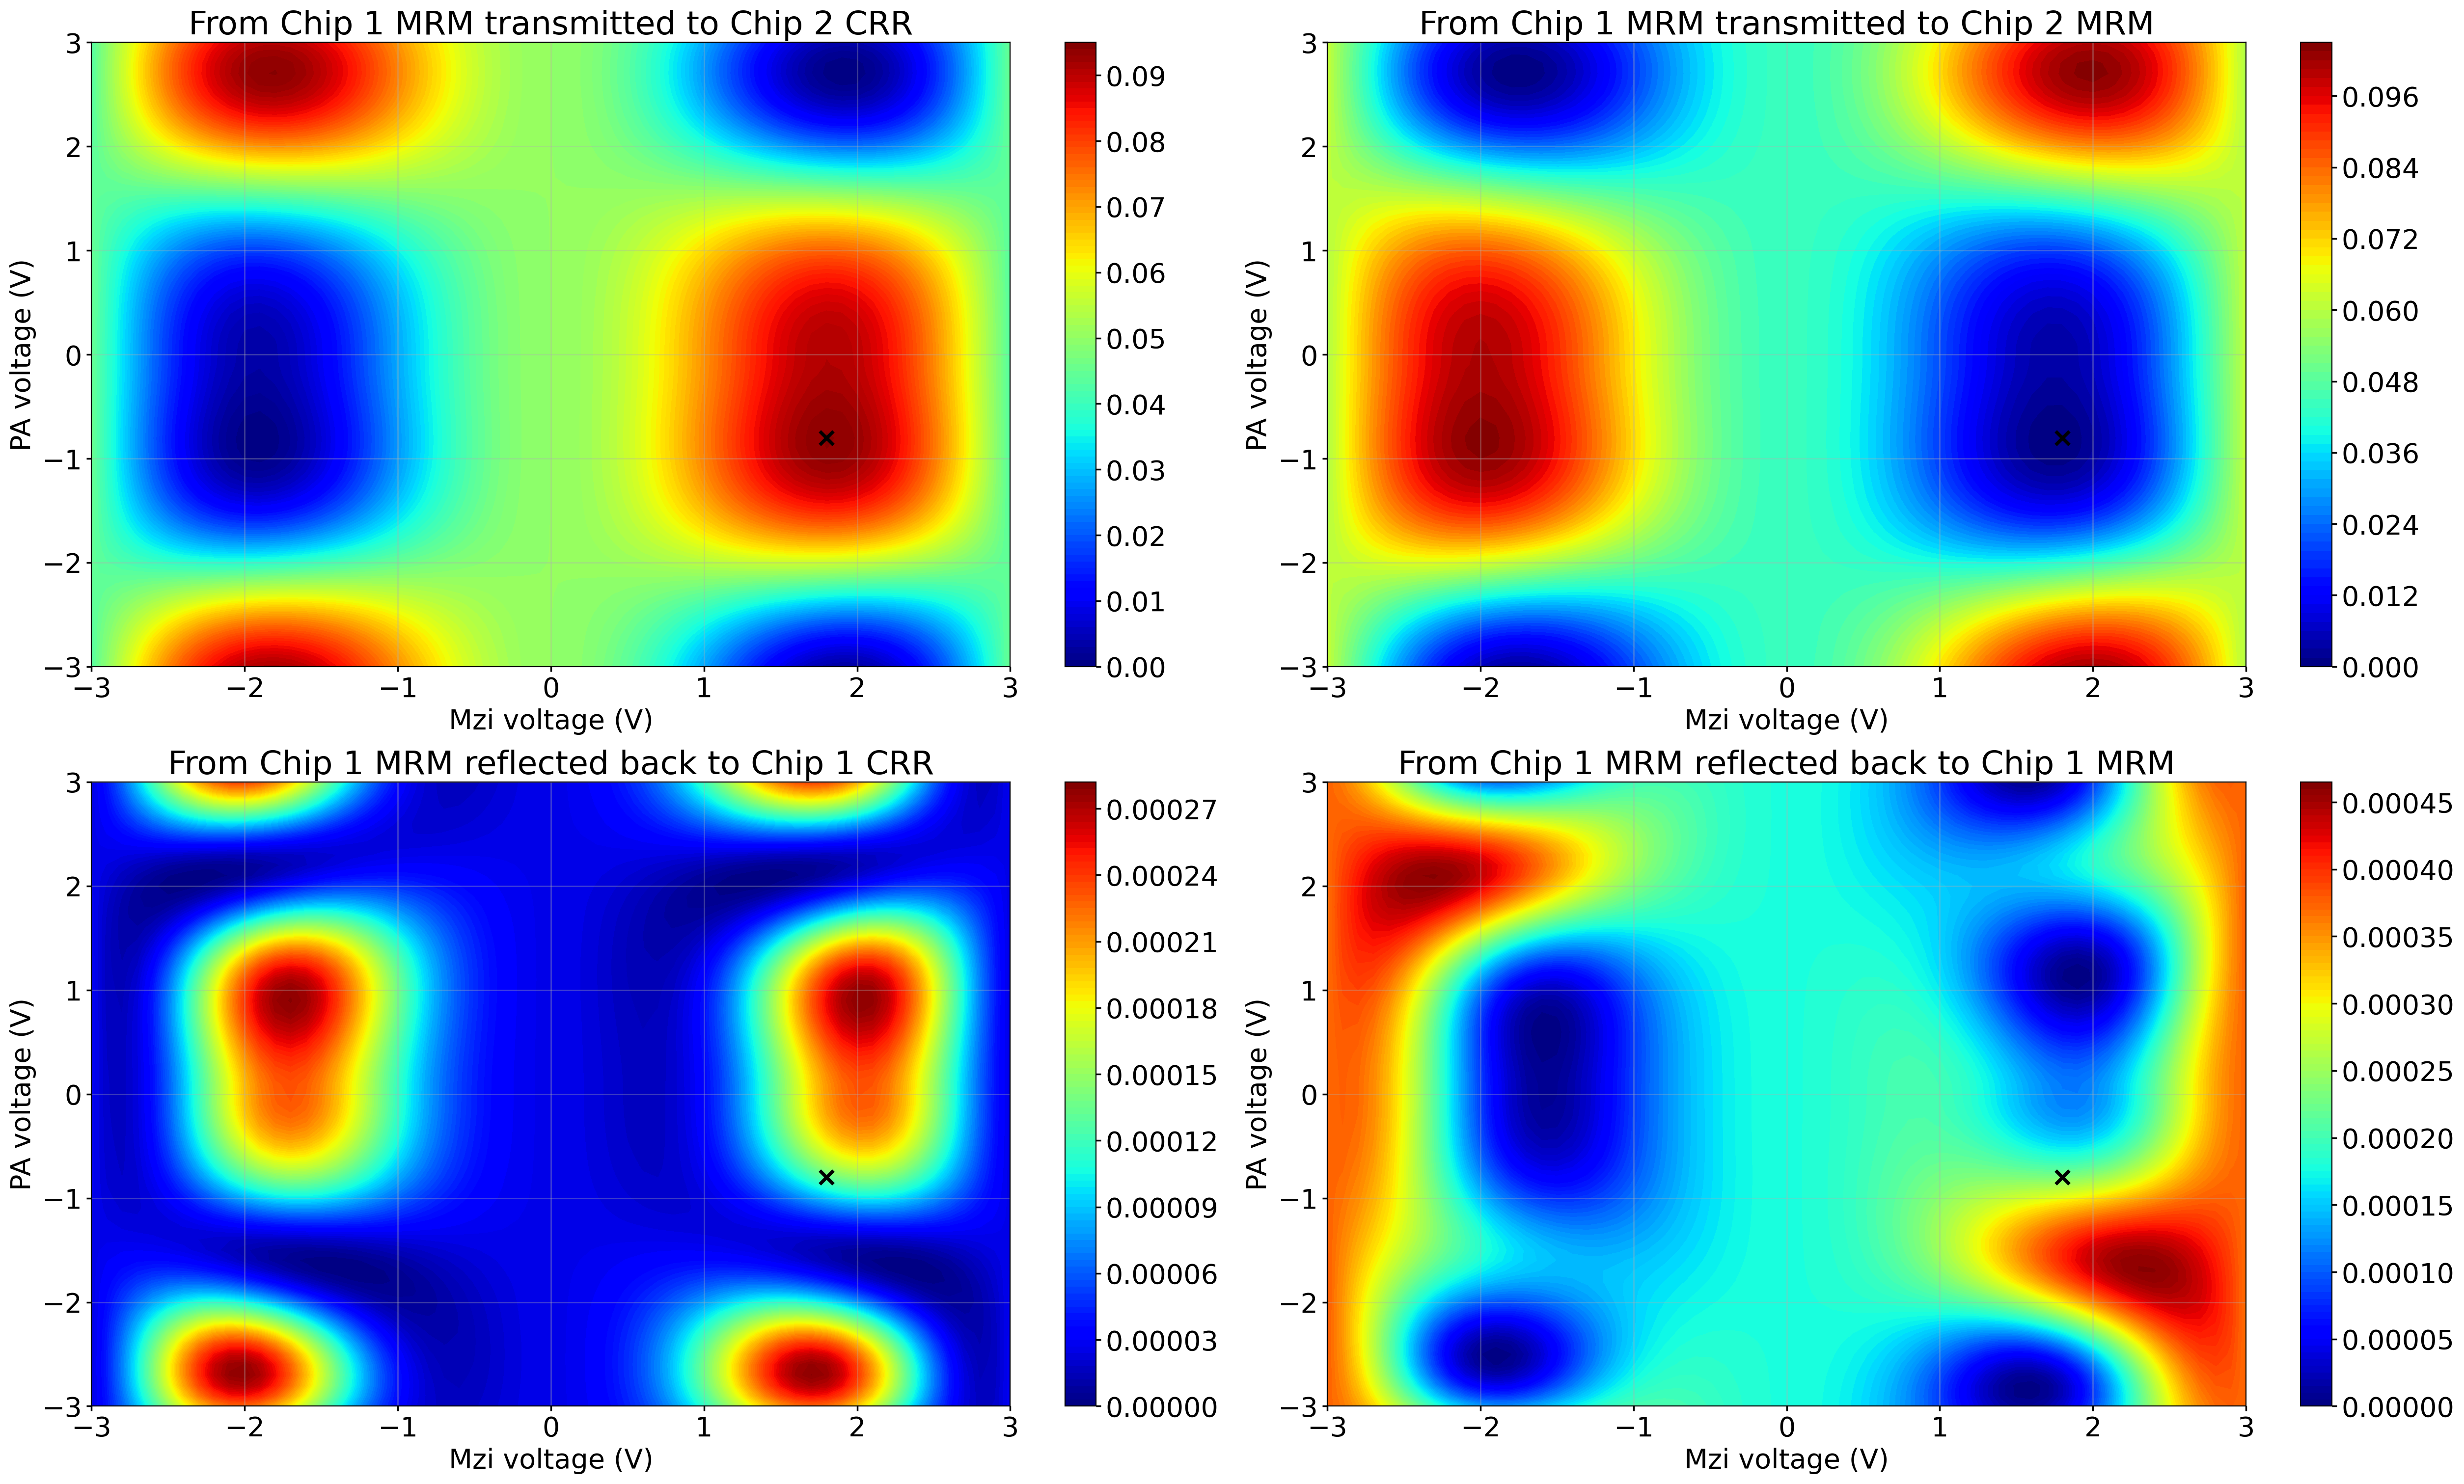

In [9]:
plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.contourf(x_meshgrid, y_meshgrid, np.array(transmit_tm_forward).reshape(no_sweep, no_sweep),  levels = 101, cmap='jet')
plt.colorbar()
plt.scatter(voltages[index_mzi], voltages[index_pa], marker='x', color='black')
plt.xlabel("Mzi voltage (V)")
plt.ylabel("PA voltage (V)")
plt.title('From Chip 1 MRM transmitted to Chip 2 CRR')
plt.subplot(2, 2, 2)
plt.contourf(x_meshgrid, y_meshgrid, np.array(transmit_te_forward).reshape(no_sweep, no_sweep), levels = 101, cmap='jet')
plt.colorbar()
plt.scatter(voltages[index_mzi], voltages[index_pa], marker='x',color='black')
plt.xlabel("Mzi voltage (V)")
plt.ylabel("PA voltage (V)")
plt.title('From Chip 1 MRM transmitted to Chip 2 MRM')
plt.subplot(2, 2, 3)
plt.contourf(x_meshgrid, y_meshgrid, np.array(reflect_tm_forward).reshape(no_sweep, no_sweep),  levels = 101, cmap='jet')
plt.colorbar()
plt.scatter(voltages[index_mzi], voltages[index_pa], marker='x',color='black')
plt.xlabel("Mzi voltage (V)")
plt.ylabel("PA voltage (V)")
plt.title('From Chip 1 MRM reflected back to Chip 1 CRR')
plt.subplot(2, 2, 4)
plt.contourf(x_meshgrid, y_meshgrid, np.array(reflect_te_forward).reshape(no_sweep, no_sweep), levels = 101, cmap='jet')
plt.colorbar()
plt.scatter(voltages[index_mzi], voltages[index_pa],marker='x',color='black')
plt.xlabel("Mzi voltage (V)")
plt.ylabel("PA voltage (V)")
plt.title('From Chip 1 MRM reflected back to Chip 1 MRM')

Text(0.5, 1.0, 'From Chip 1 MRM reflected back to Chip 1 MRM')

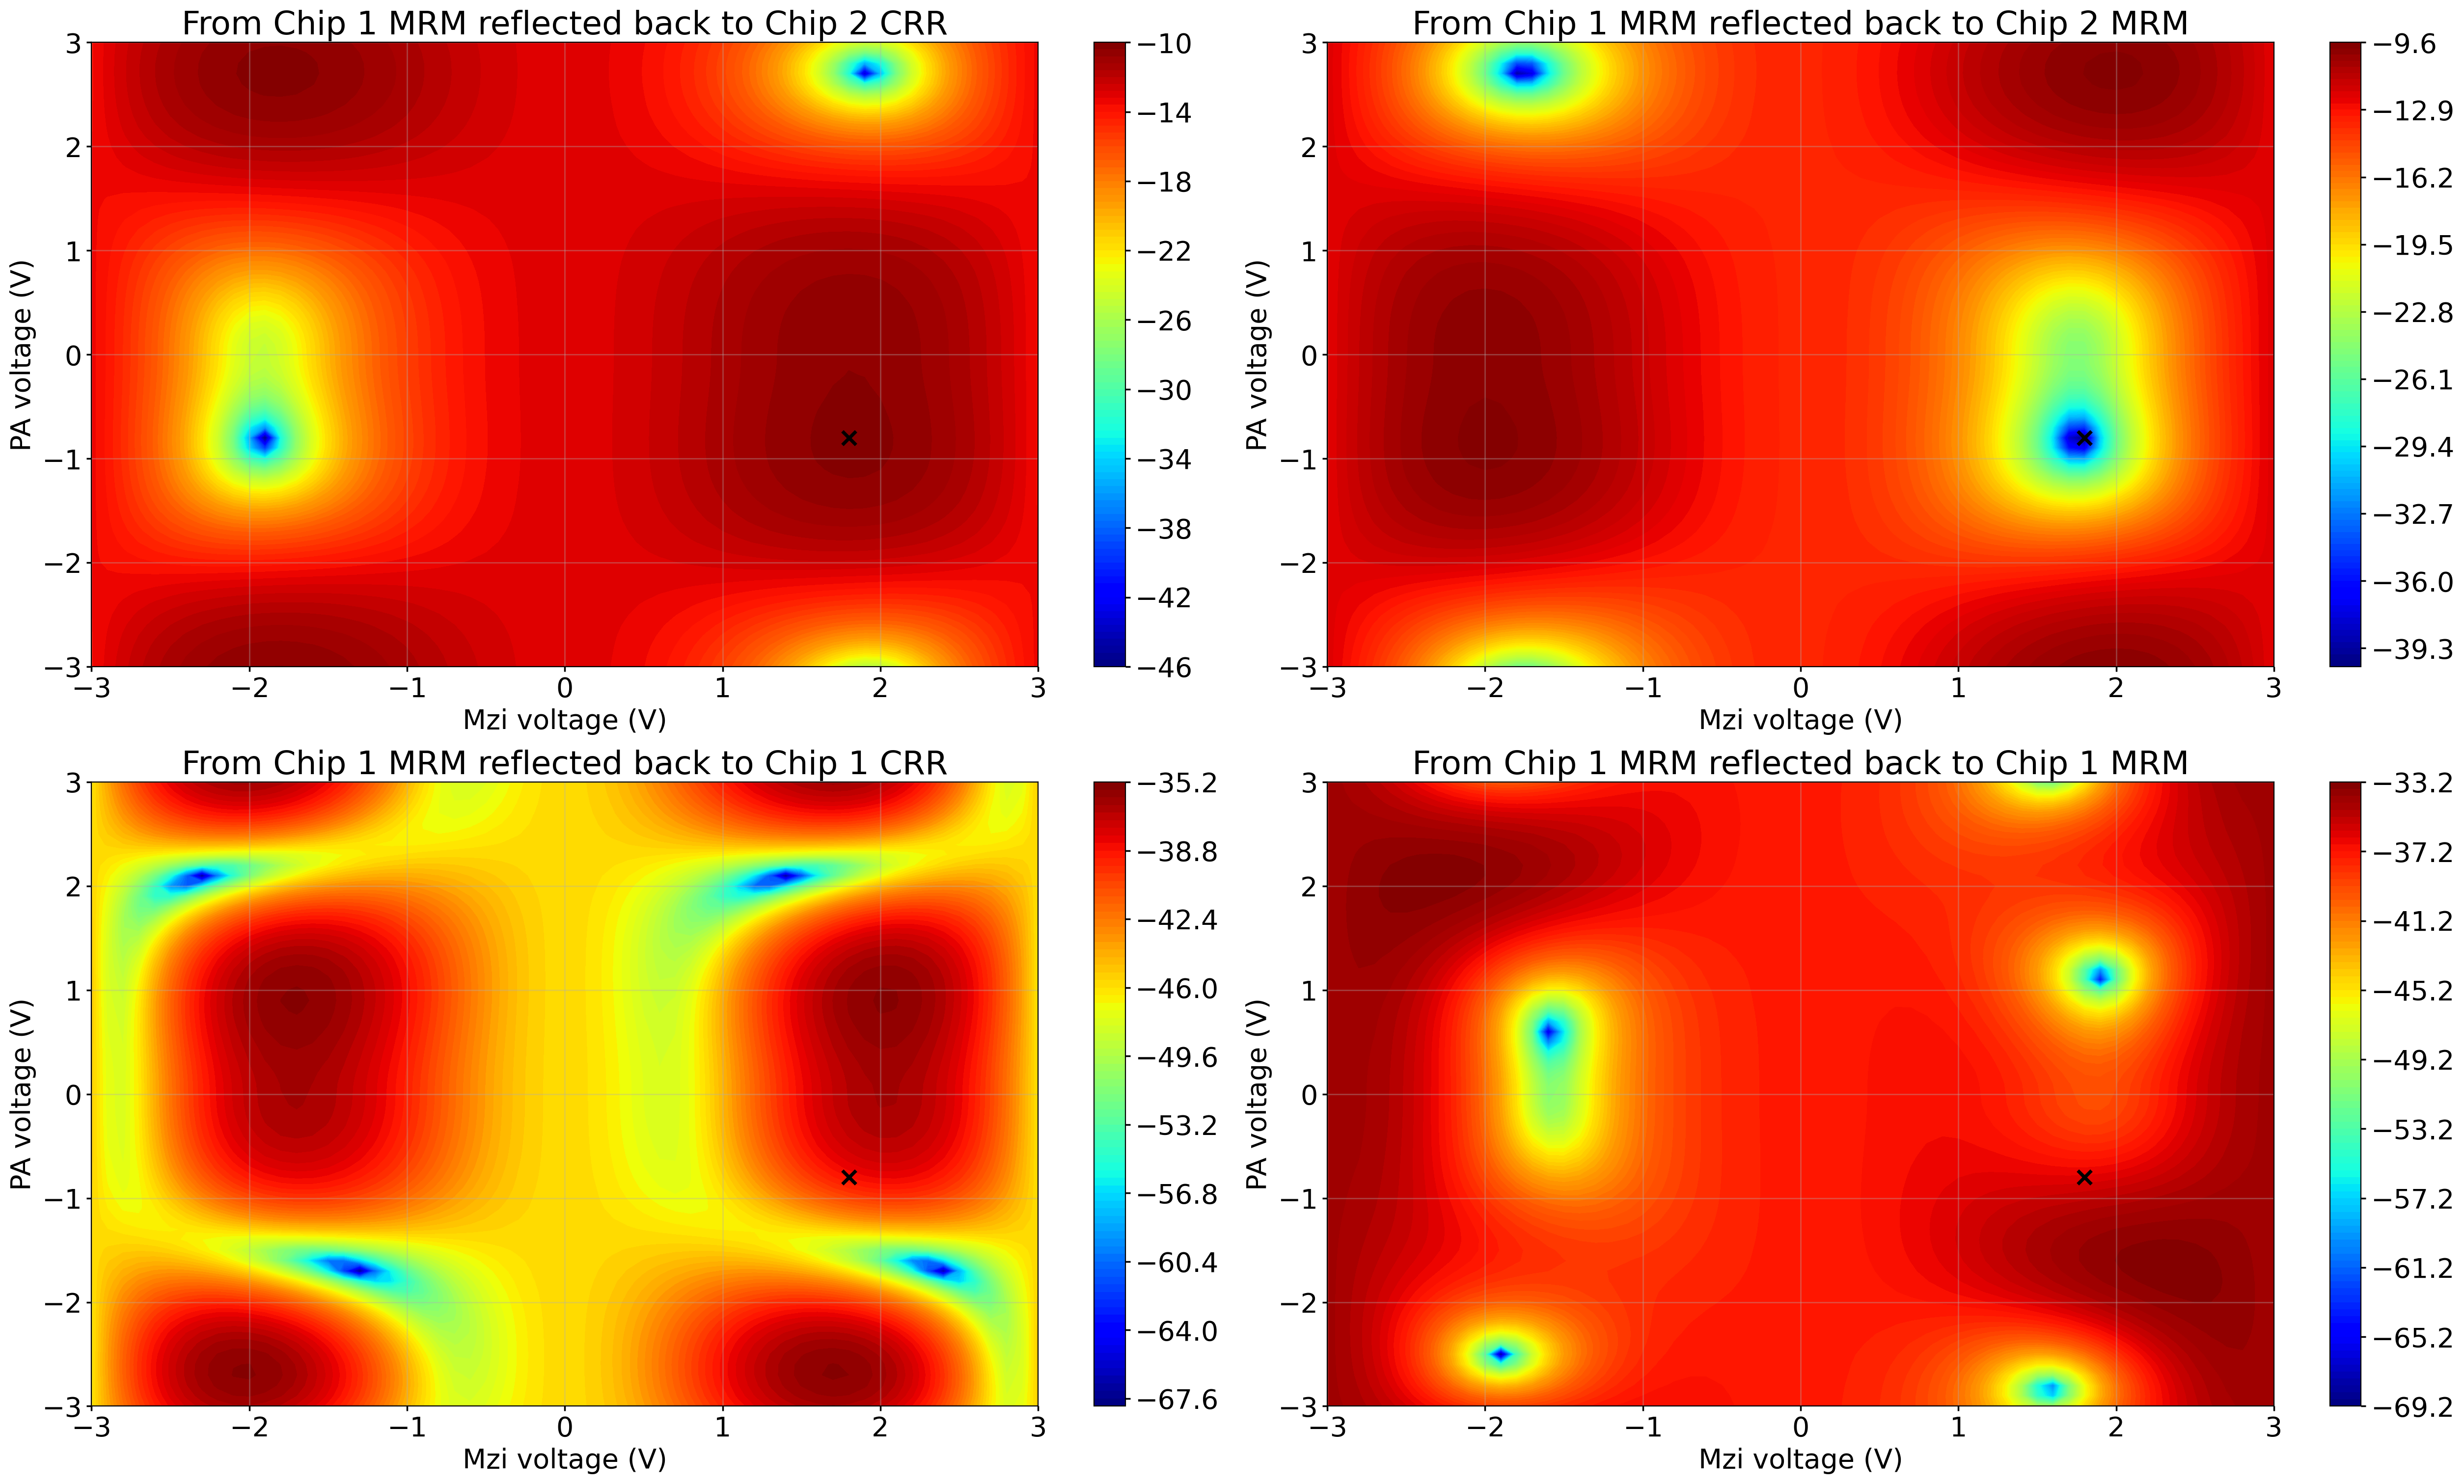

In [10]:
plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.contourf(x_meshgrid, y_meshgrid, 10*np.log10(np.array(transmit_tm_forward)).reshape(no_sweep, no_sweep),  levels = 101, cmap='jet')
plt.colorbar()
plt.scatter(voltages[index_mzi], voltages[index_pa], marker='x', color='black')
plt.xlabel("Mzi voltage (V)")
plt.ylabel("PA voltage (V)")
plt.title('Transmitted TM')
plt.title('From Chip 1 MRM reflected back to Chip 2 CRR')
plt.subplot(2, 2, 2)
plt.contourf(x_meshgrid, y_meshgrid, 10*np.log10(np.array(transmit_te_forward)).reshape(no_sweep, no_sweep), levels = 101, cmap='jet')
plt.colorbar()
plt.scatter(voltages[index_mzi], voltages[index_pa], marker='x',color='black')
plt.xlabel("Mzi voltage (V)")
plt.ylabel("PA voltage (V)")
plt.title('Transmitted TE')
plt.title('From Chip 1 MRM reflected back to Chip 2 MRM')
plt.subplot(2, 2, 3)
plt.contourf(x_meshgrid, y_meshgrid, 10*np.log10(np.array(reflect_tm_forward)).reshape(no_sweep, no_sweep),  levels = 101, cmap='jet')
plt.colorbar()
plt.scatter(voltages[index_mzi], voltages[index_pa], marker='x',color='black')
plt.xlabel("Mzi voltage (V)")
plt.ylabel("PA voltage (V)")
plt.title('Reflected TM')
plt.title('From Chip 1 MRM reflected back to Chip 1 CRR')
plt.subplot(2, 2, 4)
plt.contourf(x_meshgrid, y_meshgrid, 10*np.log10(np.array(reflect_te_forward)).reshape(no_sweep, no_sweep), levels = 101, cmap='jet')
plt.colorbar()
plt.scatter(voltages[index_mzi], voltages[index_pa],marker='x',color='black')
plt.xlabel("Mzi voltage (V)")
plt.ylabel("PA voltage (V)")
plt.title('Reflected TE')
plt.title('From Chip 1 MRM reflected back to Chip 1 MRM')

Text(0.5, 1.0, 'From Chip 1 MRM reflected back to Chip 1 MRM')

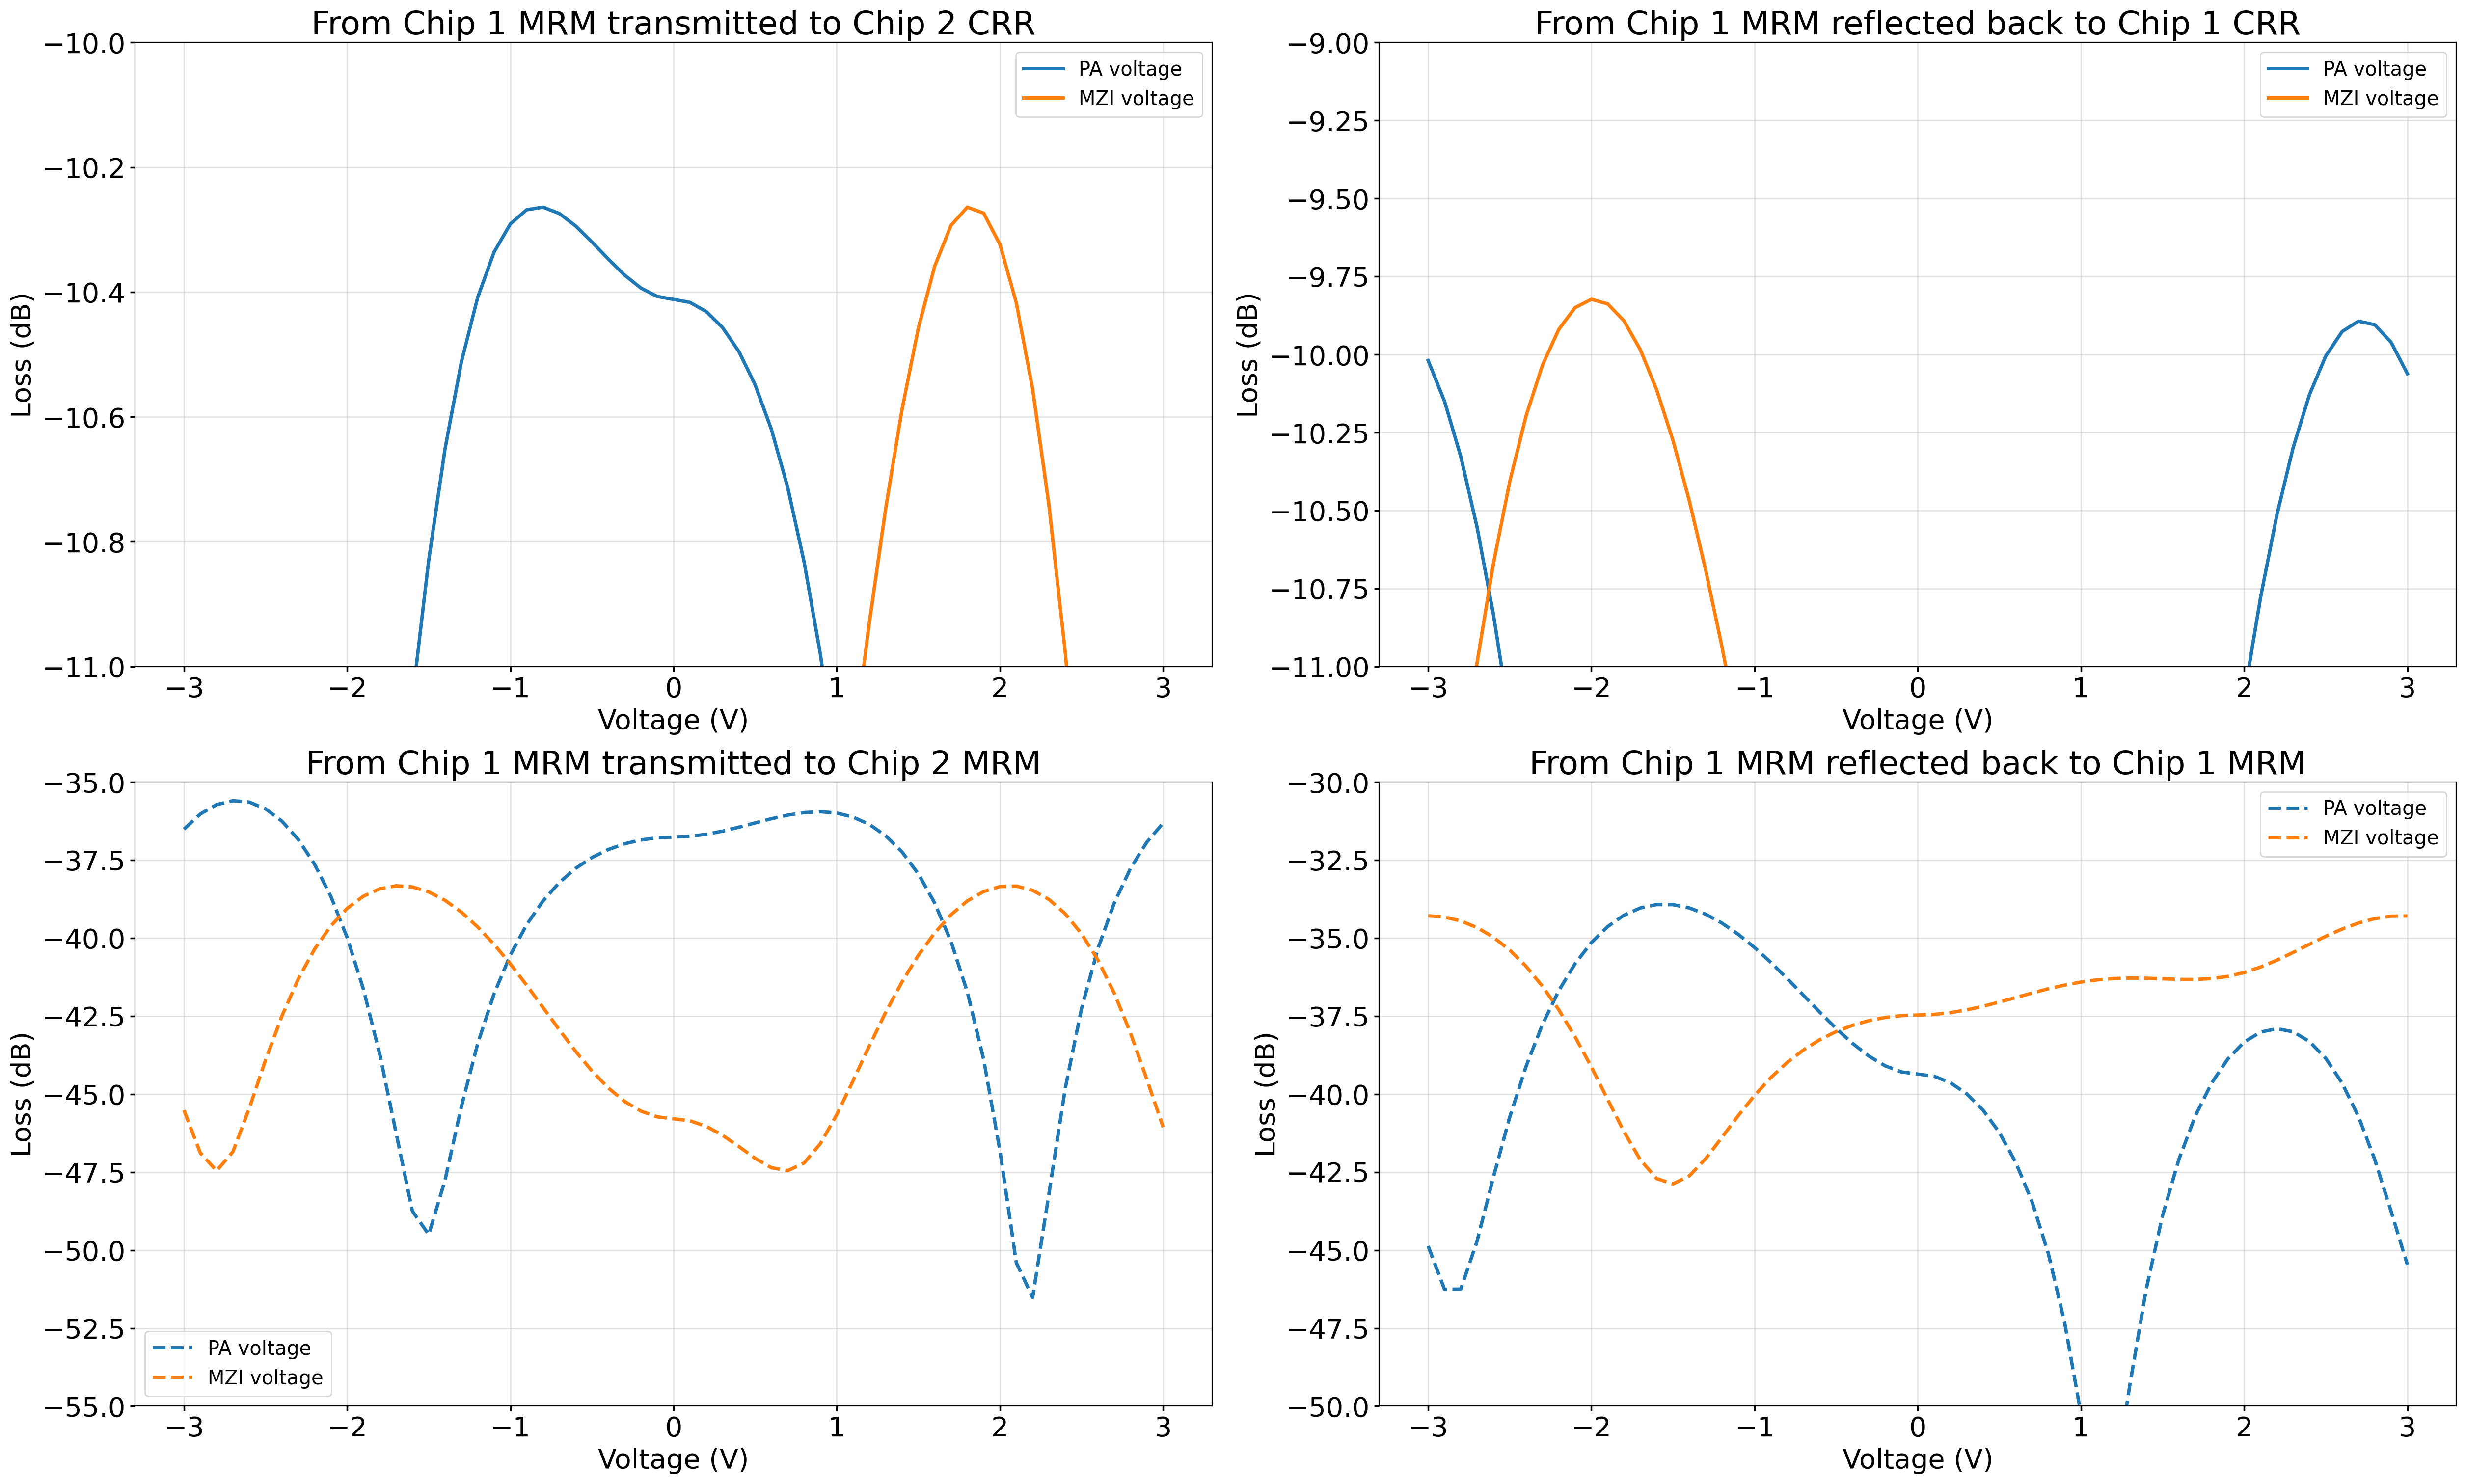

In [11]:
plt.figure(figsize=(25, 15))
plt.subplot(221)
plt.plot(voltages, 10*np.log10(np.array(transmit_tm_forward)).reshape(no_sweep, no_sweep)[:,index_mzi], label='PA voltage')
plt.plot(voltages, 10*np.log10(np.array(transmit_tm_forward)).reshape(no_sweep, no_sweep)[index_pa,:], label='MZI voltage')
plt.ylim([-11, -10])
plt.legend()
plt.xlabel("Voltage (V)")
plt.ylabel("Loss (dB)")
plt.title('From Chip 1 MRM transmitted to Chip 2 CRR')

plt.subplot(223)
plt.plot(voltages, 10*np.log10(np.array(reflect_tm_forward)).reshape(no_sweep, no_sweep)[:,index_mzi], linestyle='--',label='PA voltage')
plt.plot(voltages, 10*np.log10(np.array(reflect_tm_forward)).reshape(no_sweep, no_sweep)[index_pa,:], linestyle='--',label='MZI voltage')
plt.ylim([-55, -35])
plt.legend()
plt.xlabel("Voltage (V)")
plt.ylabel("Loss (dB)")
plt.title('From Chip 1 MRM transmitted to Chip 2 MRM')

plt.subplot(222)
plt.plot(voltages, 10*np.log10(np.array(transmit_te_forward)).reshape(no_sweep, no_sweep)[:,index_mzi], label='PA voltage')
plt.plot(voltages, 10*np.log10(np.array(transmit_te_forward)).reshape(no_sweep, no_sweep)[index_pa,:], label='MZI voltage')
plt.ylim([-11, -9])
plt.legend()
plt.xlabel("Voltage (V)")
plt.ylabel("Loss (dB)")
plt.title('From Chip 1 MRM reflected back to Chip 1 CRR')

plt.subplot(224)
plt.plot(voltages, 10*np.log10(np.array(reflect_te_forward)).reshape(no_sweep, no_sweep)[:,index_mzi], linestyle='--',label='PA voltage')
plt.plot(voltages, 10*np.log10(np.array(reflect_te_forward)).reshape(no_sweep, no_sweep)[index_pa,:], linestyle='--',label='MZI voltage')
plt.ylim([-50, -30])
plt.legend()
plt.xlabel("Voltage (V)")
plt.ylabel("Loss (dB)")
plt.title('From Chip 1 MRM reflected back to Chip 1 MRM')


Text(0.5, 1.0, 'From Chip 2 MRM reflected back to Chip 2 MRM')

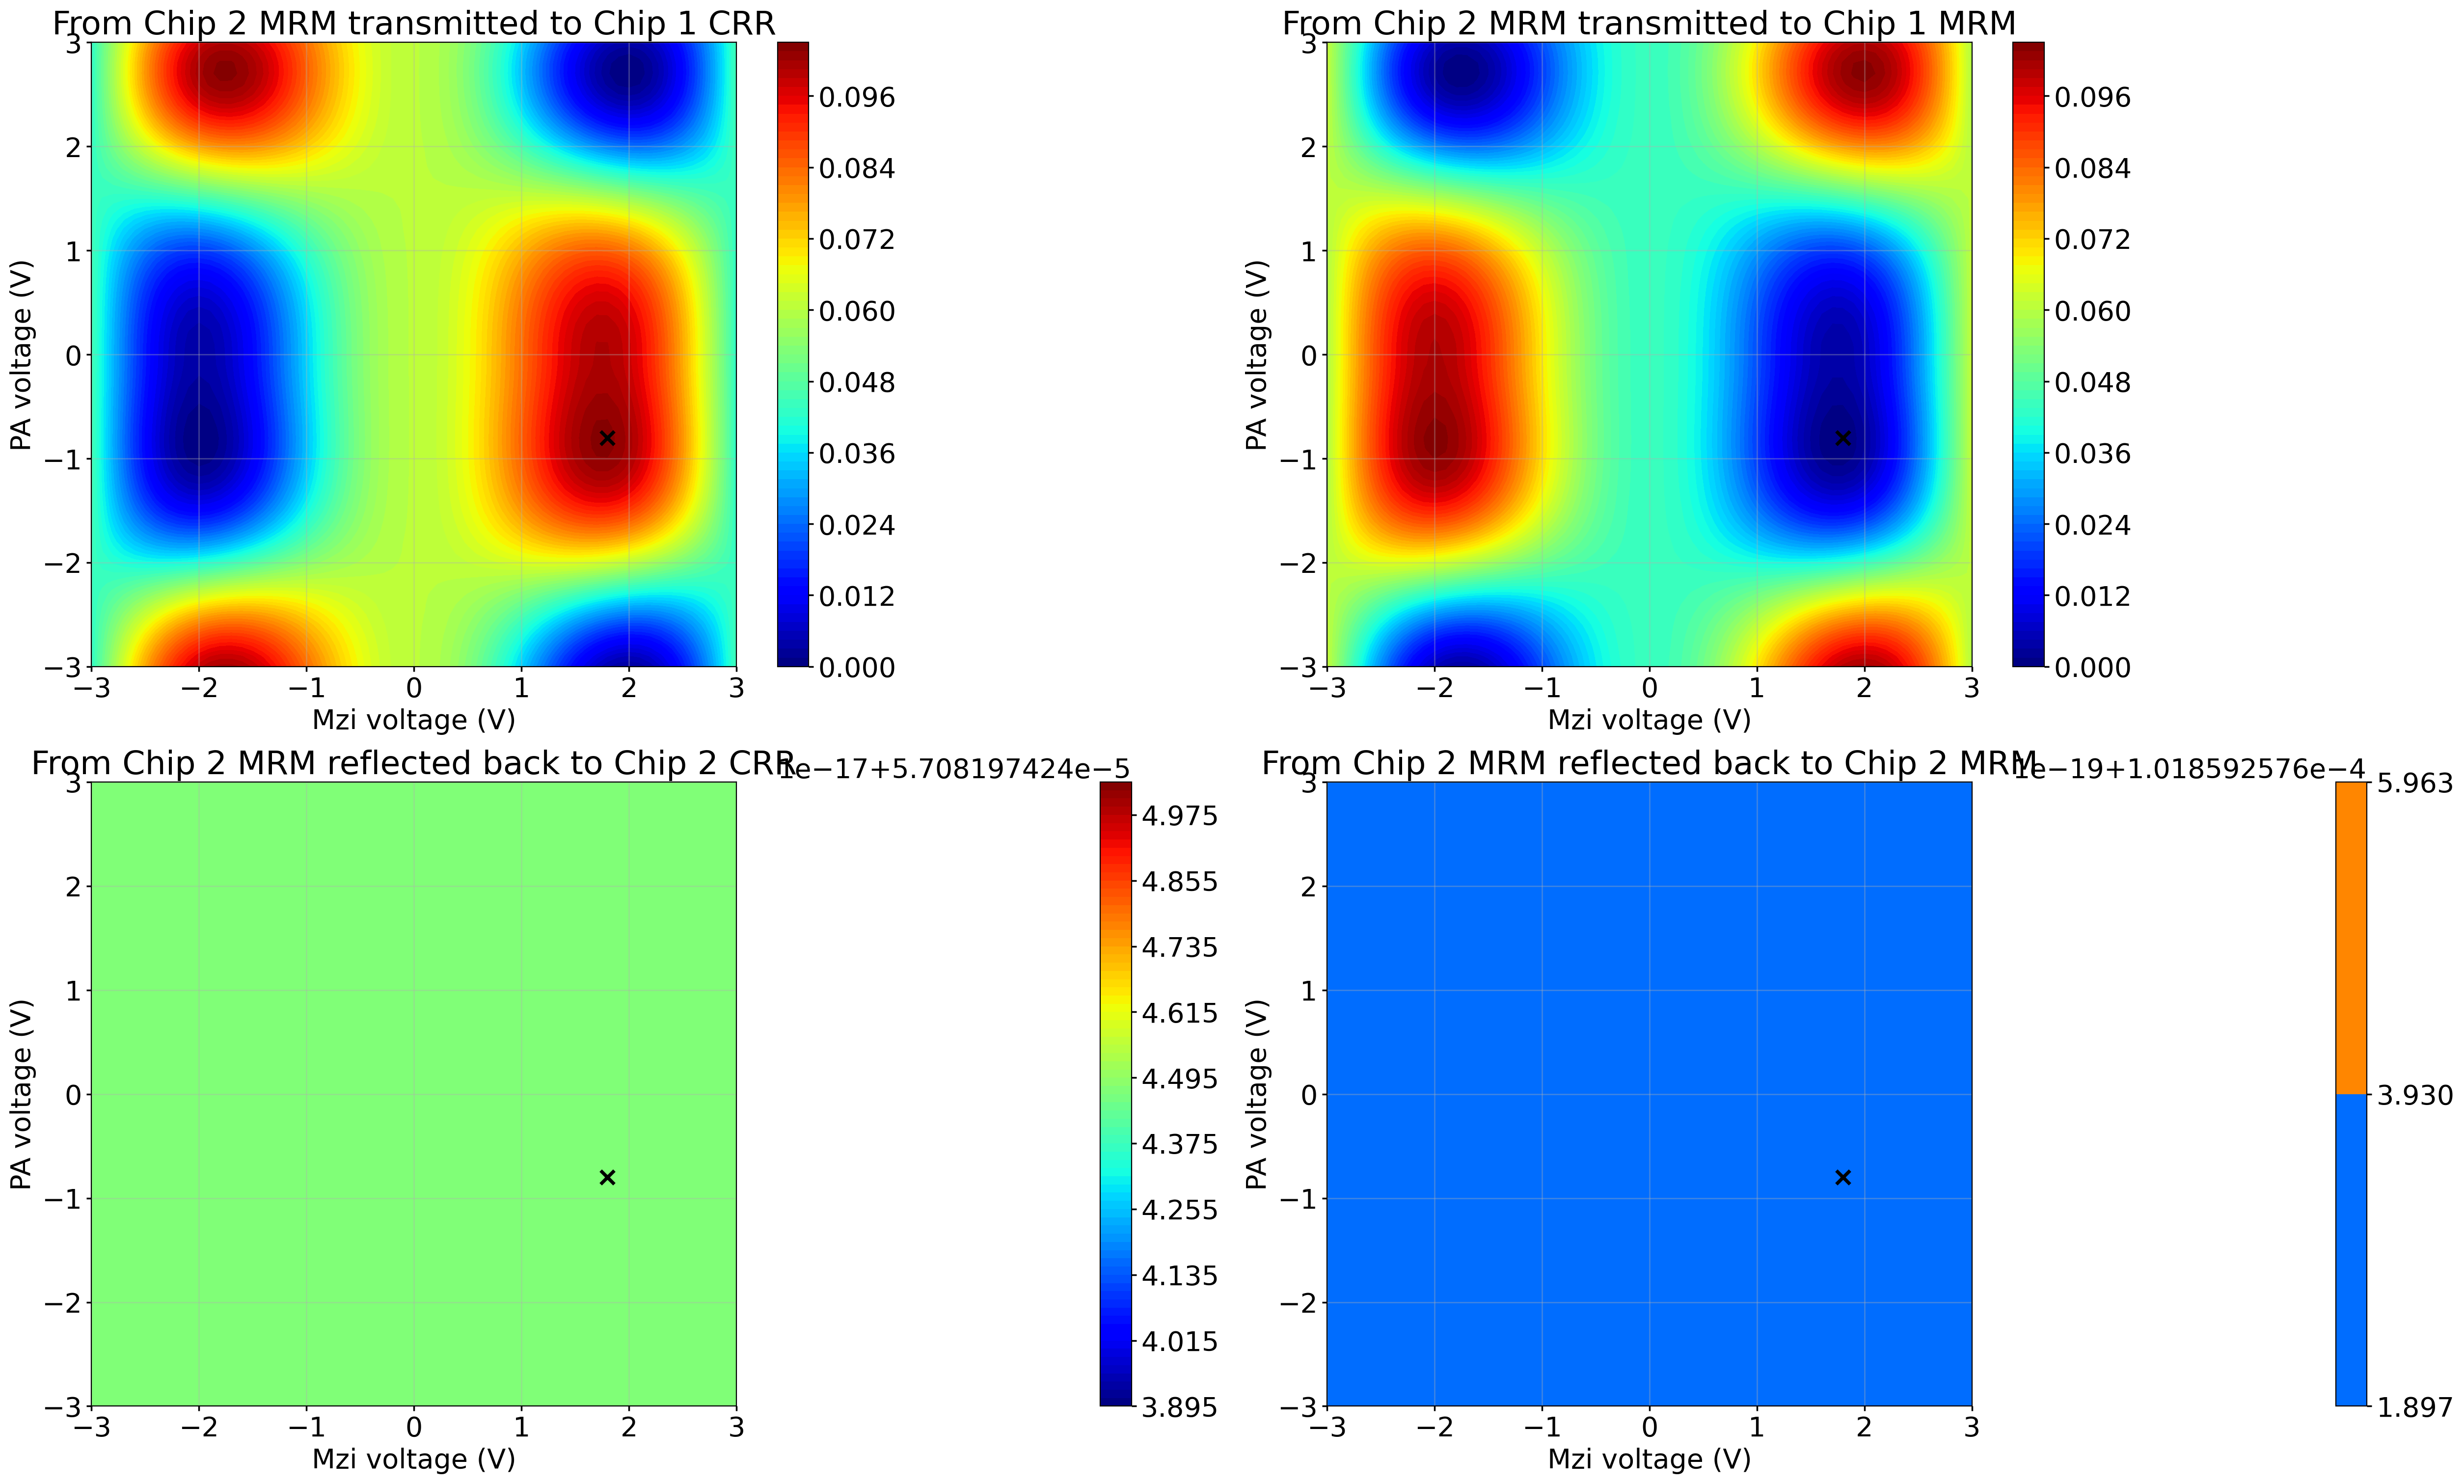

In [12]:
plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.contourf(x_meshgrid, y_meshgrid, np.array(transmit_tm_reverse).reshape(no_sweep, no_sweep),  levels = 101, cmap='jet')
plt.colorbar()
plt.scatter(voltages[index_mzi], voltages[index_pa], marker='x', color='black')
plt.xlabel("Mzi voltage (V)")
plt.ylabel("PA voltage (V)")
plt.title('From Chip 2 MRM transmitted to Chip 1 CRR')
plt.subplot(2, 2, 2)
plt.contourf(x_meshgrid, y_meshgrid, np.array(transmit_te_reverse).reshape(no_sweep, no_sweep), levels = 101, cmap='jet')
plt.colorbar()
plt.scatter(voltages[index_mzi], voltages[index_pa], marker='x',color='black')
plt.xlabel("Mzi voltage (V)")
plt.ylabel("PA voltage (V)")
plt.title('From Chip 2 MRM transmitted to Chip 1 MRM')
plt.subplot(2, 2, 3)
plt.contourf(x_meshgrid, y_meshgrid, np.array(reflect_tm_reverse).reshape(no_sweep, no_sweep),  levels = 101, cmap='jet')
plt.colorbar()
plt.scatter(voltages[index_mzi], voltages[index_pa], marker='x',color='black')
plt.xlabel("Mzi voltage (V)")
plt.ylabel("PA voltage (V)")
plt.title('From Chip 2 MRM reflected back to Chip 2 CRR')
plt.subplot(2, 2, 4)
plt.contourf(x_meshgrid, y_meshgrid, np.array(reflect_te_reverse).reshape(no_sweep, no_sweep), levels = 101, cmap='jet')
plt.colorbar()
plt.scatter(voltages[index_mzi], voltages[index_pa],marker='x',color='black')
plt.xlabel("Mzi voltage (V)")
plt.ylabel("PA voltage (V)")
plt.title('From Chip 2 MRM reflected back to Chip 2 MRM')

Text(0.5, 1.0, 'From Chip 2 MRM reflected back to Chip 2 MRM')

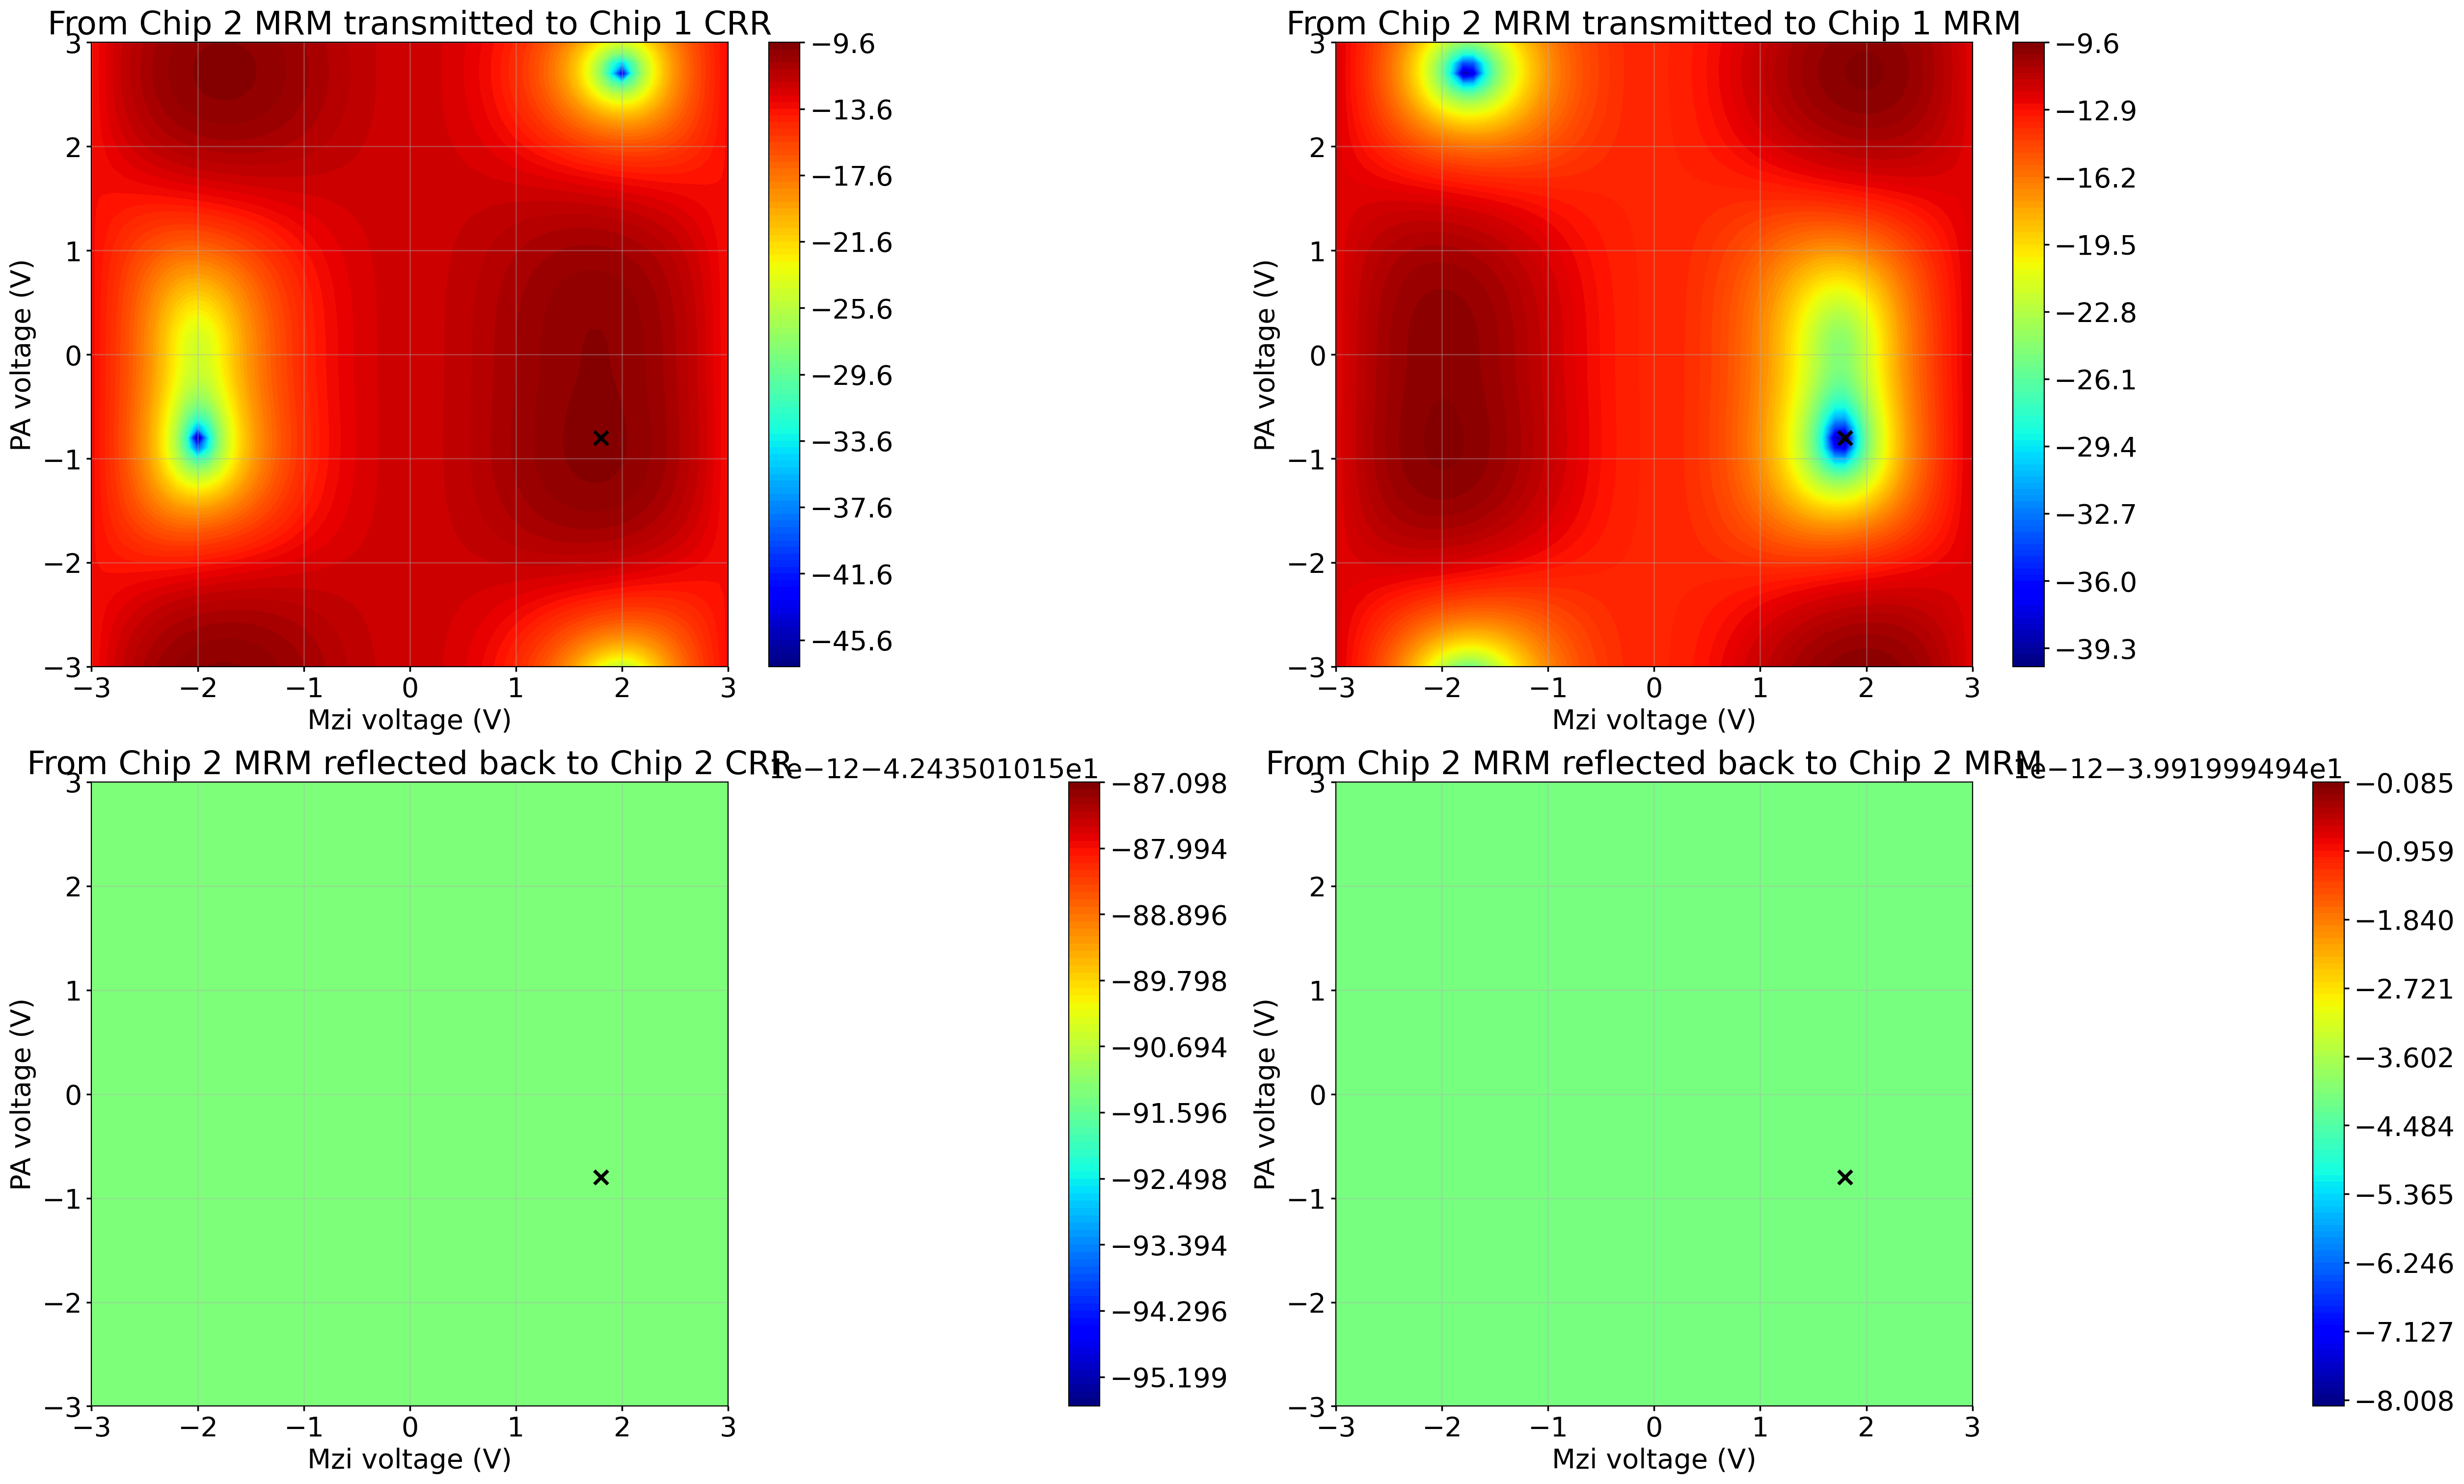

In [13]:
plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.contourf(x_meshgrid, y_meshgrid, 10*np.log10(np.array(transmit_tm_reverse)).reshape(no_sweep, no_sweep),  levels = 101, cmap='jet')
plt.colorbar()
plt.scatter(voltages[index_mzi], voltages[index_pa], marker='x', color='black')
plt.xlabel("Mzi voltage (V)")
plt.ylabel("PA voltage (V)")
plt.title('From Chip 2 MRM transmitted to Chip 1 CRR')
plt.subplot(2, 2, 2)
plt.contourf(x_meshgrid, y_meshgrid, 10*np.log10(np.array(transmit_te_reverse)).reshape(no_sweep, no_sweep), levels = 101, cmap='jet')
plt.colorbar()
plt.scatter(voltages[index_mzi], voltages[index_pa], marker='x',color='black')
plt.xlabel("Mzi voltage (V)")
plt.ylabel("PA voltage (V)")
plt.title('From Chip 2 MRM transmitted to Chip 1 MRM')
plt.subplot(2, 2, 3)
plt.contourf(x_meshgrid, y_meshgrid, 10*np.log10(np.array(reflect_tm_reverse)).reshape(no_sweep, no_sweep),  levels = 101, cmap='jet')
plt.colorbar()
plt.scatter(voltages[index_mzi], voltages[index_pa], marker='x',color='black')
plt.xlabel("Mzi voltage (V)")
plt.ylabel("PA voltage (V)")
plt.title('From Chip 2 MRM reflected back to Chip 2 CRR')
plt.subplot(2, 2, 4)
plt.contourf(x_meshgrid, y_meshgrid, 10*np.log10(np.array(reflect_te_reverse)).reshape(no_sweep, no_sweep), levels = 101, cmap='jet')
plt.colorbar()
plt.scatter(voltages[index_mzi], voltages[index_pa],marker='x',color='black')
plt.xlabel("Mzi voltage (V)")
plt.ylabel("PA voltage (V)")
plt.title('From Chip 2 MRM reflected back to Chip 2 MRM')

Text(0.5, 1.0, 'From Chip 2 MRM reflected back to Chip 2 MRM')

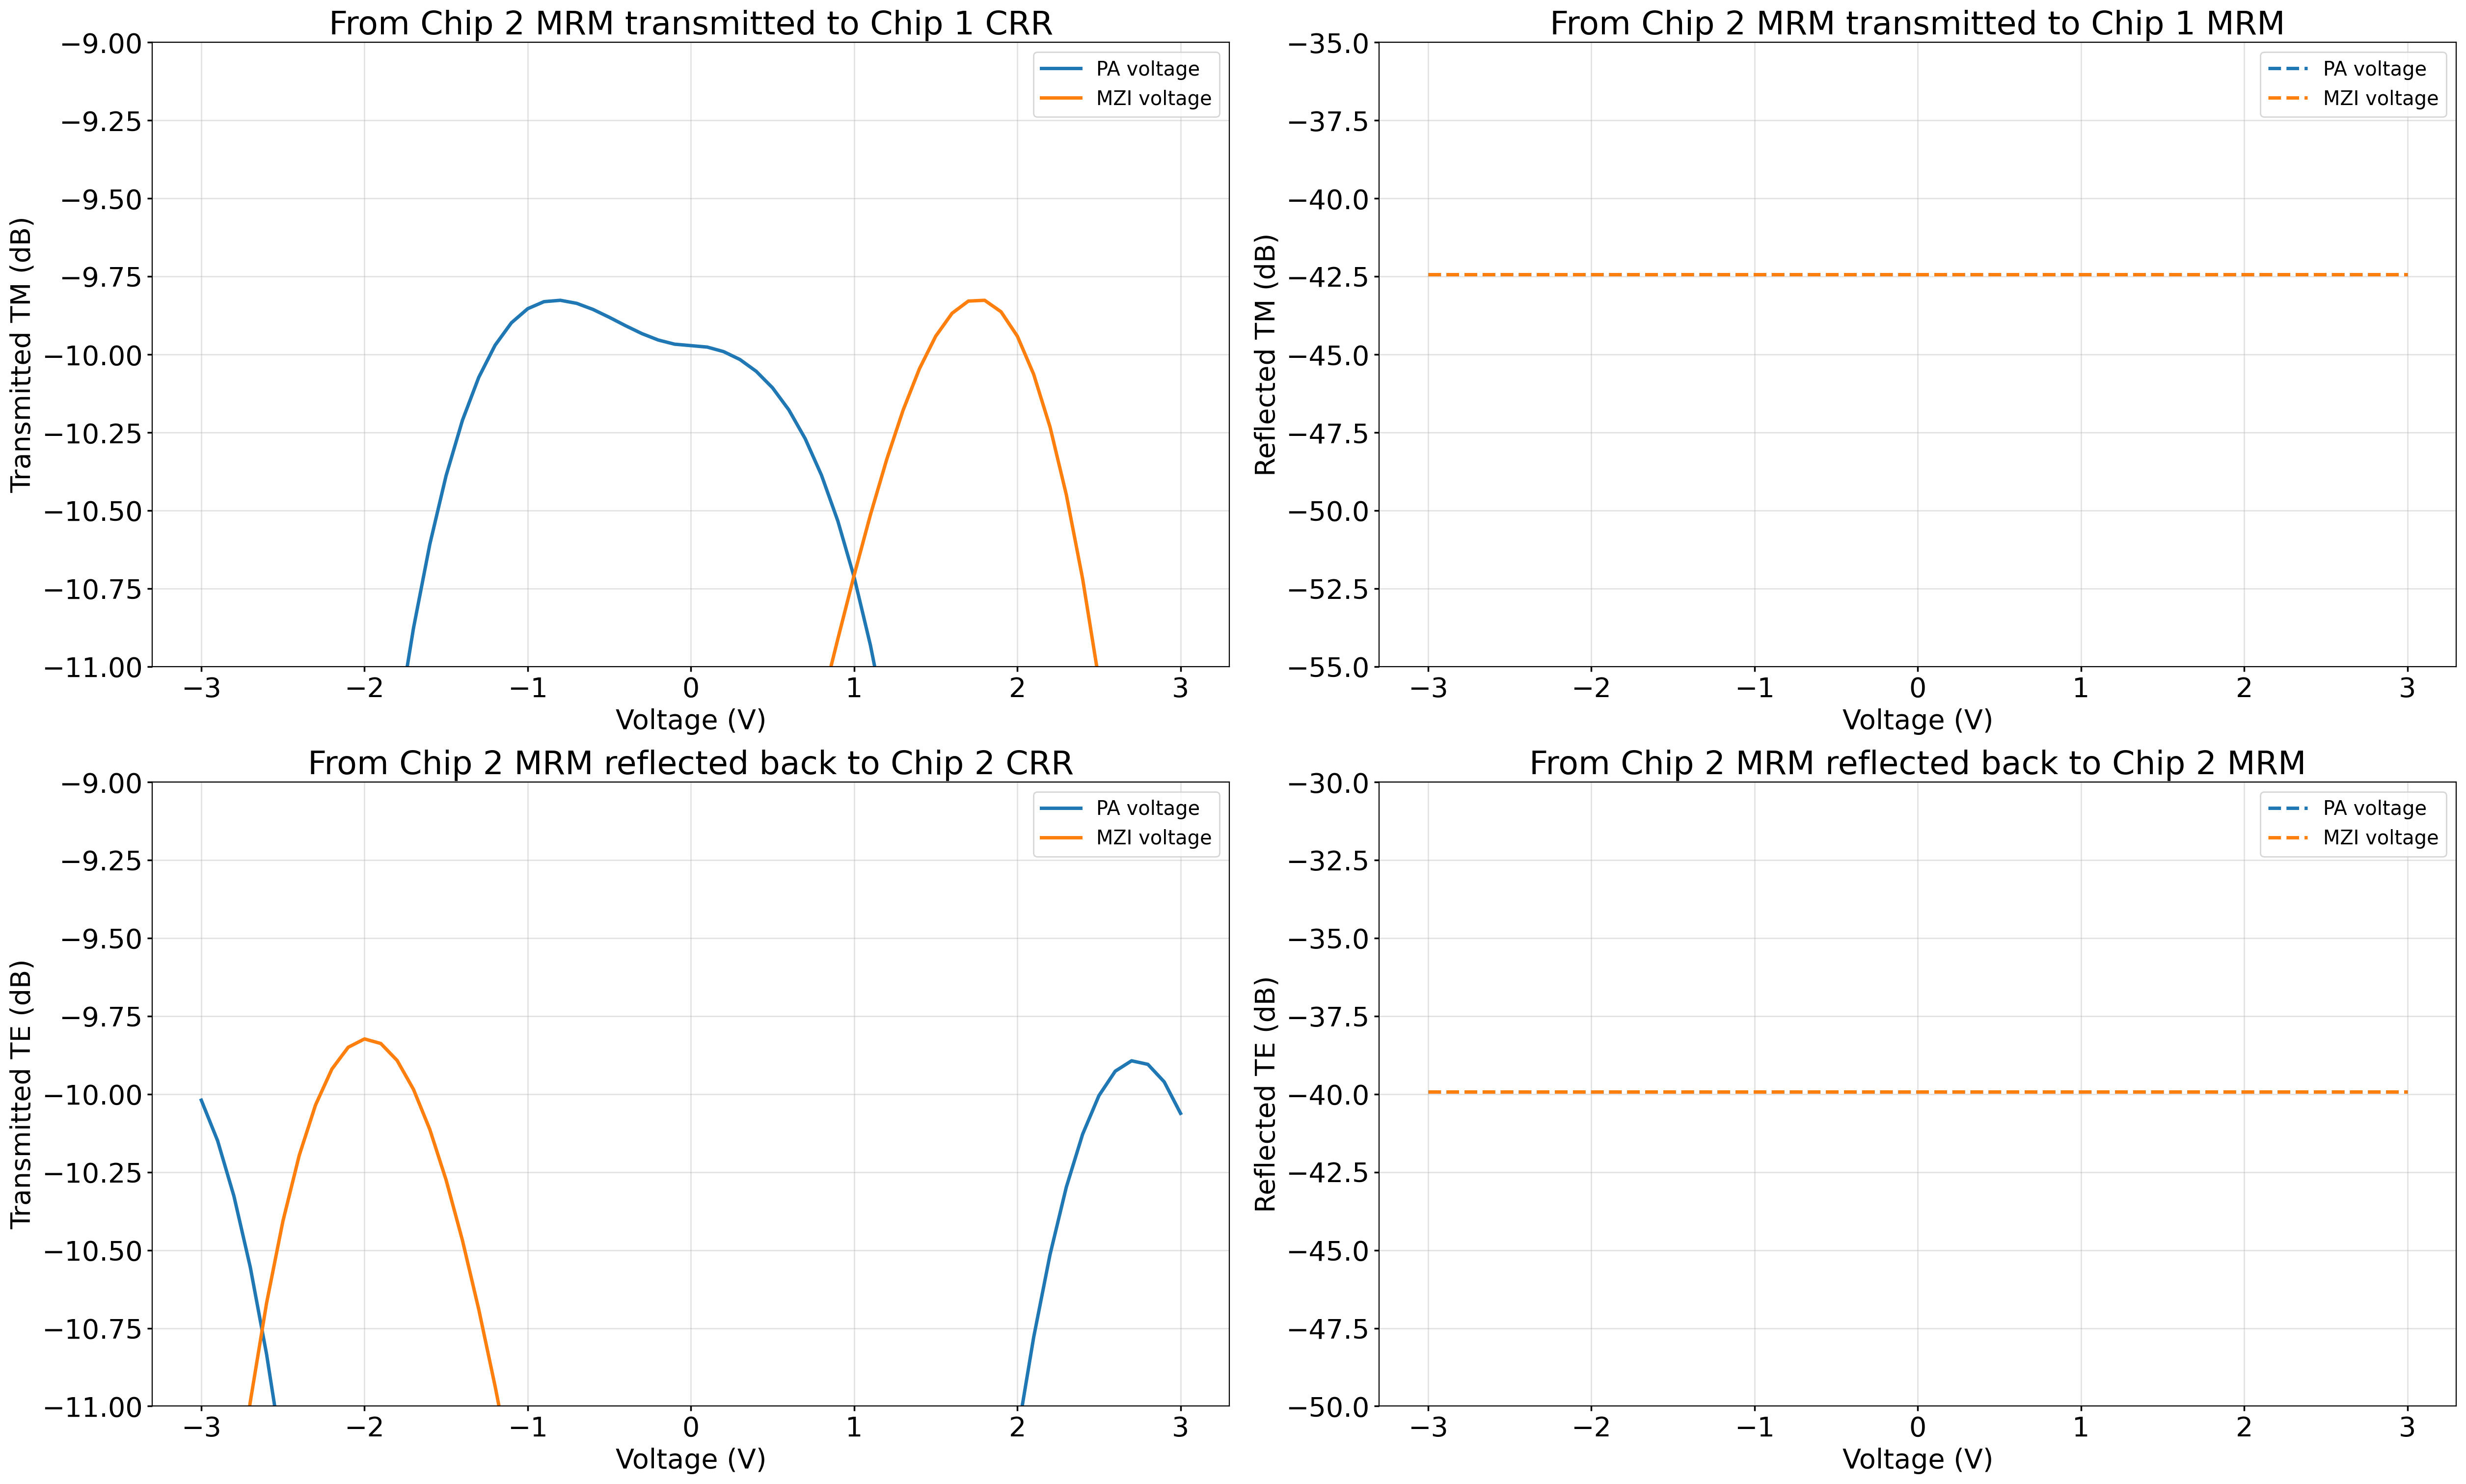

In [14]:
plt.figure(figsize=(25, 15))
plt.subplot(221)
plt.plot(voltages, 10*np.log10(np.array(transmit_tm_reverse)).reshape(no_sweep, no_sweep)[:,index_mzi], label='PA voltage')
plt.plot(voltages, 10*np.log10(np.array(transmit_tm_reverse)).reshape(no_sweep, no_sweep)[index_pa,:], label='MZI voltage')
plt.ylim([-11, -9])
plt.legend()
plt.xlabel("Voltage (V)")
plt.ylabel("Transmitted TM (dB)")
plt.title('From Chip 2 MRM transmitted to Chip 1 CRR')

plt.subplot(222)
plt.plot(voltages, 10*np.log10(np.array(reflect_tm_reverse)).reshape(no_sweep, no_sweep)[:,index_mzi], linestyle='--',label='PA voltage')
plt.plot(voltages, 10*np.log10(np.array(reflect_tm_reverse)).reshape(no_sweep, no_sweep)[index_pa,:], linestyle='--',label='MZI voltage')
plt.ylim([-55, -35])
plt.legend()
plt.xlabel("Voltage (V)")
plt.ylabel("Reflected TM (dB)")
plt.title('From Chip 2 MRM transmitted to Chip 1 MRM')

plt.subplot(223)
plt.plot(voltages, 10*np.log10(np.array(transmit_te_reverse)).reshape(no_sweep, no_sweep)[:,index_mzi], label='PA voltage')
plt.plot(voltages, 10*np.log10(np.array(transmit_te_reverse)).reshape(no_sweep, no_sweep)[index_pa,:], label='MZI voltage')
plt.ylim([-11, -9])
plt.legend()
plt.xlabel("Voltage (V)")
plt.ylabel("Transmitted TE (dB)")
plt.title('From Chip 2 MRM reflected back to Chip 2 CRR')

plt.subplot(224)
plt.plot(voltages, 10*np.log10(np.array(reflect_te_reverse)).reshape(no_sweep, no_sweep)[:,index_mzi], linestyle='--',label='PA voltage')
plt.plot(voltages, 10*np.log10(np.array(reflect_te_reverse)).reshape(no_sweep, no_sweep)[index_pa,:], linestyle='--',label='MZI voltage')
plt.ylim([-50, -30])
plt.legend()
plt.xlabel("Voltage (V)")
plt.ylabel("Reflected TE (dB)")
plt.title('From Chip 2 MRM reflected back to Chip 2 MRM')
